# Data Loading

In [2]:
import os
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
def load_and_concat_csvs(folder_path):
    all_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".csv")
    ]
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [4]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATASET_PATH = os.path.join(PROJECT_ROOT, "dataset")

print("Project root:", PROJECT_ROOT)
print("Dataset path:", DATASET_PATH)

Project root: e:\Ajinkya STUDY\UIDAI
Dataset path: e:\Ajinkya STUDY\UIDAI\dataset


In [5]:
BASE_PATH = "dataset"

enrolment_path = os.path.join(DATASET_PATH, "api_data_aadhar_enrolment")
demographic_path = os.path.join(DATASET_PATH, "api_data_aadhar_demographic")
biometric_path = os.path.join(DATASET_PATH, "api_data_aadhar_biometric")

enrolment_df = load_and_concat_csvs(enrolment_path)
demographic_df = load_and_concat_csvs(demographic_path)
biometric_df = load_and_concat_csvs(biometric_path)

In [6]:
print("Enrolment:", enrolment_df.shape)
print("Demographic:", demographic_df.shape)
print("Biometric:", biometric_df.shape)

enrolment_df.head()

Enrolment: (1006029, 7)
Demographic: (2071700, 6)
Biometric: (1861108, 6)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [7]:
def standardise_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
    )
    return df

enrolment_df = standardise_columns(enrolment_df)
demographic_df = standardise_columns(demographic_df)
biometric_df = standardise_columns(biometric_df)

In [8]:
def clean_keys(df):
    df["state"] = df["state"].astype(str).str.strip()
    df["district"] = df["district"].astype(str).str.strip()
    df["pincode"] = df["pincode"].astype(str).str.strip()
    return df

enrolment_df = clean_keys(enrolment_df)
demographic_df = clean_keys(demographic_df)
biometric_df = clean_keys(biometric_df)

In [9]:
enrolment_df.duplicated(
    subset=["state", "district", "pincode"],
    keep=False
).sum()

np.int64(1004421)

In [10]:
enrolment_df = (
    enrolment_df
    .groupby(["state", "district", "pincode"], as_index=False)
    .agg({
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)

In [11]:
demographic_df = (
    demographic_df
    .groupby(["state", "district", "pincode"], as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum"
    })
)

In [12]:
biometric_df = (
    biometric_df
    .groupby(["state", "district", "pincode"], as_index=False)
    .agg({
        "bio_age_5_17": "sum",
        "bio_age_17_": "sum"
    })
)

In [13]:
print(enrolment_df.shape)
print(demographic_df.shape)
print(biometric_df.shape)

(28982, 6)
(31495, 5)
(31295, 5)


In [14]:
master_df = enrolment_df.merge(
    demographic_df,
    on=["state", "district", "pincode"],
    how="left"
)

master_df = master_df.merge(
    biometric_df,
    on=["state", "district", "pincode"],
    how="left"
)

In [15]:
update_cols = [
    "demo_age_5_17",
    "demo_age_17_",
    "bio_age_5_17",
    "bio_age_17_"
]

master_df[update_cols] = master_df[update_cols].fillna(0)

In [16]:
master_df.shape

(28982, 10)

# Feature Engineering

### Goal of this phase

Convert raw counts into:

1. Normalised ratios
2. Lifecycle indicators
3. Update stress signals

These features are what anomaly detection will operate on.

In [17]:
master_df["total_enrolment"] = (
    master_df["age_0_5"]
    + master_df["age_5_17"]
    + master_df["age_18_greater"]
)

master_df["total_demo_updates"] = (
    master_df["demo_age_5_17"]
    + master_df["demo_age_17_"]
)

master_df["total_bio_updates"] = (
    master_df["bio_age_5_17"]
    + master_df["bio_age_17_"]
)

In [18]:
master_df[["total_enrolment", "total_demo_updates", "total_bio_updates"]].describe()

,total_enrolment,total_demo_updates,total_bio_updates
count,28982.000000,28982.000000,28982.000000
mean,187.554413,1700.086605,2406.577945
std,466.975480,3723.587799,3892.912770
min,1.000000,0.000000,0.000000
25%,18.000000,152.000000,255.000000
50%,59.000000,569.000000,1106.000000
75%,173.000000,1736.000000,2933.000000
max,15122.000000,115643.000000,78727.000000


In [ ]:
# Enrollment structure ratios (WHO is enrolling)
# These capture late vs early identity adoption.

master_df["child_enrol_ratio"] = (
    (master_df["age_0_5"] + master_df["age_5_17"])
    / master_df["total_enrolment"]
)

master_df["adult_enrol_ratio"] = (
    master_df["age_18_greater"]
    / master_df["total_enrolment"]
)

In [ ]:
# Update intensity ratios (HOW MUCH correction happens)

master_df["demo_update_ratio"] = (
    master_df["total_demo_updates"]
    / master_df["total_enrolment"]
)

master_df["bio_update_ratio"] = (
    master_df["total_bio_updates"]
    / master_df["total_enrolment"]
)

In [22]:
# Lifecycle efficiency indicators (KEY INSIGHT FEATURES)
master_df["update_efficiency"] = (
    (master_df["total_demo_updates"] + master_df["total_bio_updates"])
    / master_df["total_enrolment"]
)

# Adult update pressure - Measures how update-heavy adult lifecycle is.
master_df["adult_update_pressure"] = (
    (master_df["demo_age_17_"] + master_df["bio_age_17_"])
    / master_df["age_18_greater"].replace(0, np.nan)
)

# Child lifecycle gap - Expected: kids enrolled → kids updated over time.
master_df["child_update_gap"] = 1 - (
    (master_df["demo_age_5_17"] + master_df["bio_age_5_17"])
    / (master_df["age_0_5"] + master_df["age_5_17"]).replace(0, np.nan)
)

In [24]:
# Handle infinities & NaNs safely - This is not “cleaning”, this is correct modelling.

ratio_columns = [
    "child_enrol_ratio",
    "adult_enrol_ratio",
    "demo_update_ratio",
    "bio_update_ratio",
    "update_efficiency",
    "adult_update_pressure",
    "child_update_gap"
]

master_df[ratio_columns] = (
    master_df[ratio_columns]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

In [26]:
master_df.to_csv("outputs/master_dataset_phase3_features.csv", index=False)

# Phase 3: EXPLORATORY DATA ANALYSIS (EDA)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

### UNIVARIATE ANALYSIS
#### Purpose: Understand distributions and dominance

In [28]:
# Distribution of enrolments by age group
age_totals = {
    "0–5": master_df["age_0_5"].sum(),
    "5–17": master_df["age_5_17"].sum(),
    "18+": master_df["age_18_greater"].sum()
}

age_totals

{'0–5': np.int64(3546965), '5–17': np.int64(1720384), '18+': np.int64(168353)}

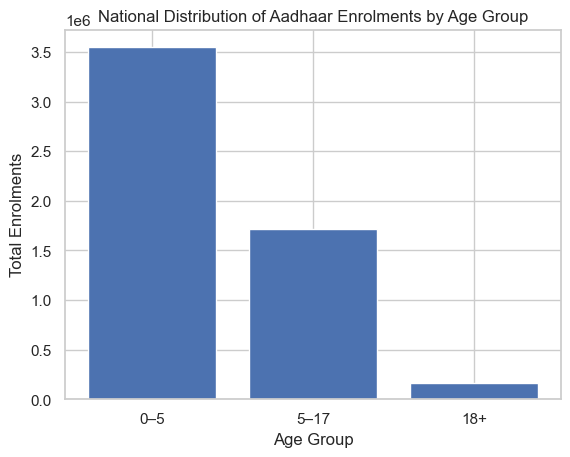

In [29]:
plt.figure()
plt.bar(age_totals.keys(), age_totals.values())
plt.title("National Distribution of Aadhaar Enrolments by Age Group")
plt.ylabel("Total Enrolments")
plt.xlabel("Age Group")
plt.show()

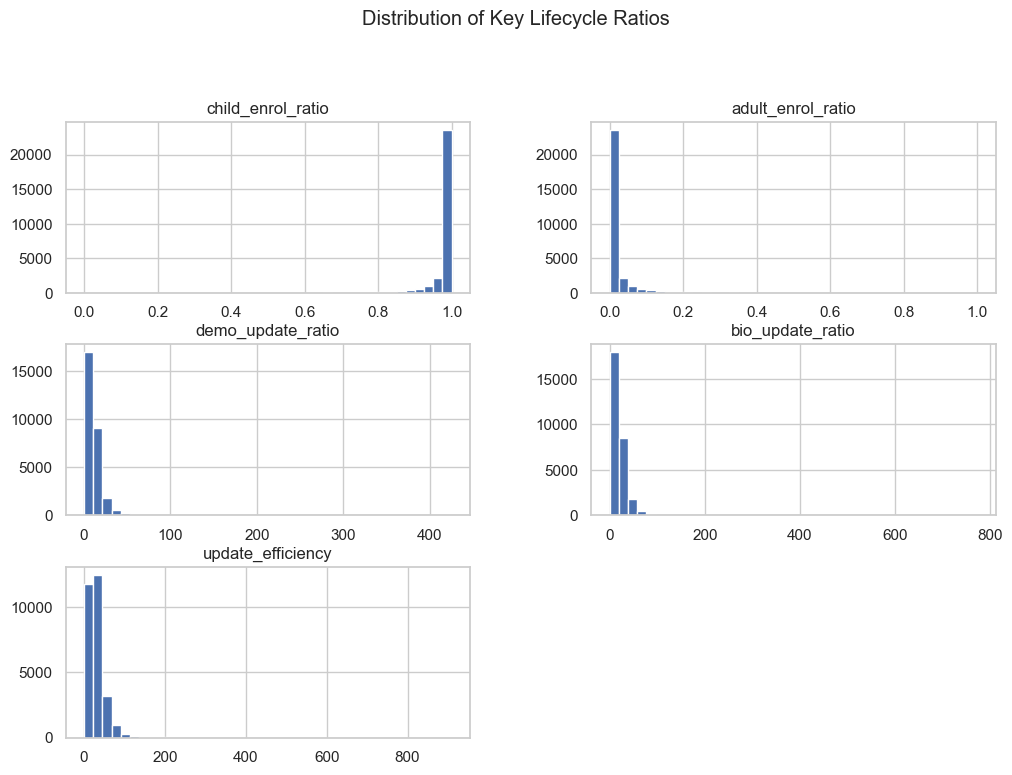

In [30]:
ratio_cols = [
    "child_enrol_ratio",
    "adult_enrol_ratio",
    "demo_update_ratio",
    "bio_update_ratio",
    "update_efficiency"
]

master_df[ratio_cols].hist(bins=40, figsize=(12, 8))
plt.suptitle("Distribution of Key Lifecycle Ratios", y=1.02)
plt.show()

## BIVARIATE ANALYSIS
### Purpose: Relationships between variables

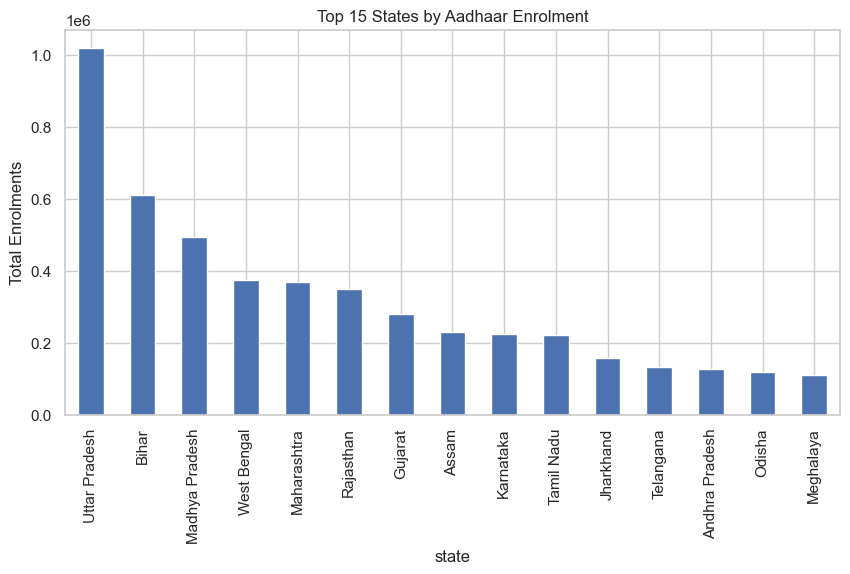

In [ ]:
# State vs enrolments

state_enrol = (
    master_df
    .groupby("state")["total_enrolment"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 5))
state_enrol.plot(kind="bar")
plt.title("Top 15 States by Aadhaar Enrolment")
plt.ylabel("Total Enrolments")
plt.show()

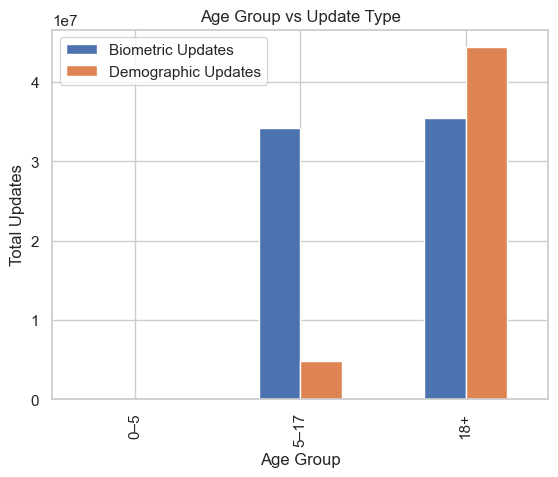

In [32]:
# Age group vs update type

age_update_df = pd.DataFrame({
    "Age Group": ["0–5", "5–17", "18+"],
    "Biometric Updates": [
        master_df["bio_age_5_17"].sum() * 0,  # none expected
        master_df["bio_age_5_17"].sum(),
        master_df["bio_age_17_"].sum()
    ],
    "Demographic Updates": [
        0,
        master_df["demo_age_5_17"].sum(),
        master_df["demo_age_17_"].sum()
    ]
})

age_update_df.set_index("Age Group").plot(kind="bar")
plt.title("Age Group vs Update Type")
plt.ylabel("Total Updates")
plt.show()

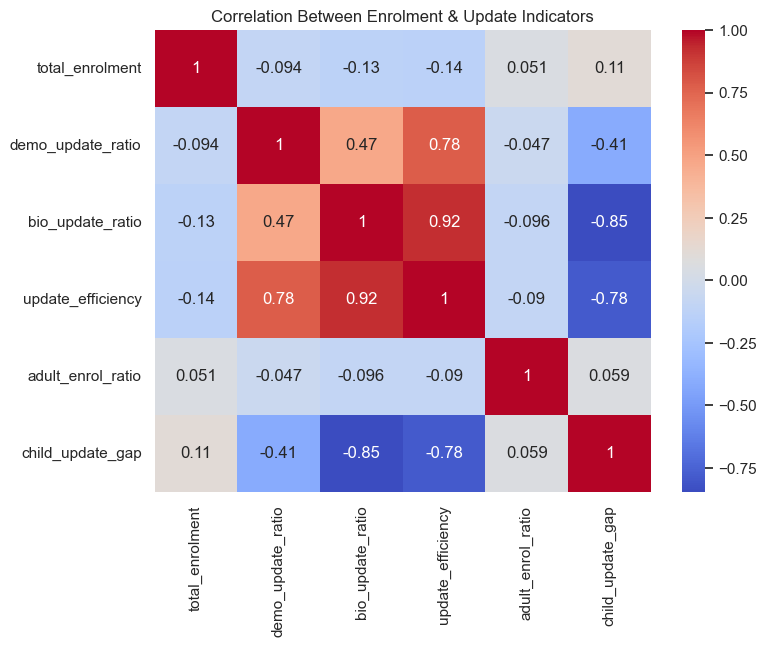

In [34]:
# Correlation heatmap (core relationship view)
corr_features = [
    "total_enrolment",
    "demo_update_ratio",
    "bio_update_ratio",
    "update_efficiency",
    "adult_enrol_ratio",
    "child_update_gap"
]

plt.figure(figsize=(8, 6))
sns.heatmap(
    master_df[corr_features].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Between Enrolment & Update Indicators")
plt.show()

## TRIVARIATE ANALYSIS
### Purpose: Multi-dimensional behavior

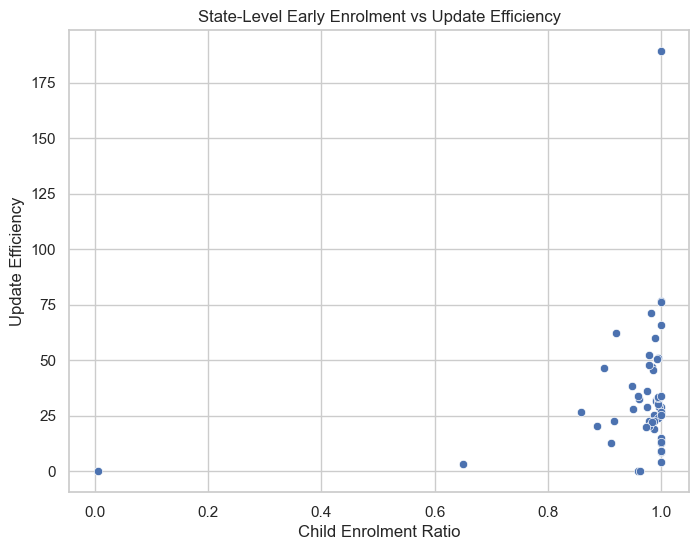

In [36]:
# State × Age × Update Efficiency

state_age_eff = (
    master_df
    .groupby("state")[["child_enrol_ratio", "update_efficiency"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=state_age_eff,
    x="child_enrol_ratio",
    y="update_efficiency"
)
plt.title("State-Level Early Enrolment vs Update Efficiency")
plt.xlabel("Child Enrolment Ratio")
plt.ylabel("Update Efficiency")
plt.show()

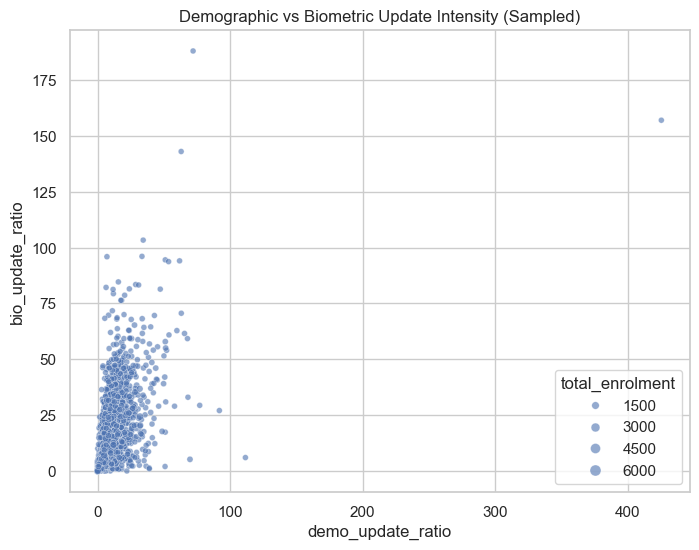

In [37]:
# District/Pincode × Update Type × Load
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=master_df.sample(2000, random_state=42),
    x="demo_update_ratio",
    y="bio_update_ratio",
    size="total_enrolment",
    alpha=0.6
)
plt.title("Demographic vs Biometric Update Intensity (Sampled)")
plt.show()